# Whole sky map

## packages 

In [1]:
from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR
import os
import argparse
from astropy.io import fits

import glob
import pickle
import Models
import os
import sys
import PIL
import data_loader
import sys, os

In [2]:
print(os.getcwd())

C:\Users\Administrator\Desktop\4\Experiment_4_10trails


## path

In [3]:

base_path = os.getcwd()
data_path  = os.path.join(base_path, 'data')
data_cube_path = os.path.join(data_path, 'saury2014','cubes')
fcnm_path = os.path.join(data_path, 'saury2014','fcnm')
rhi_path = os.path.join(data_path, 'saury2014','RHI')
print(data_cube_path)
print(fcnm_path)
print(rhi_path)

C:\Users\Administrator\Desktop\4\Experiment_4_10trails\data\saury2014\cubes
C:\Users\Administrator\Desktop\4\Experiment_4_10trails\data\saury2014\fcnm
C:\Users\Administrator\Desktop\4\Experiment_4_10trails\data\saury2014\RHI


In [4]:
# Training and test datasets
# 1. Datacubes: 04 datacubes with size of (512 x 512 x 101)
training_data_file_q0 = 'Tb_n01_pw02_vs12_512_thick_quarter_0_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q1 = 'Tb_n01_pw02_vs12_512_thick_quarter_1_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q2 = 'Tb_n01_pw02_vs12_512_thick_quarter_2_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q3 = 'Tb_n01_pw02_vs12_512_thick_quarter_3_noise_1.0_K_beam_1.45_pix_.fits'

training_data_file_q0 = os.path.join(data_cube_path, training_data_file_q0)
training_data_file_q1 = os.path.join(data_cube_path, training_data_file_q1)
training_data_file_q2 = os.path.join(data_cube_path, training_data_file_q2)
training_data_file_q3 = os.path.join(data_cube_path, training_data_file_q3)

# 2a. R_HI maps
rhi_file_q0 = 'R_map_n01_pw02_vs12_512px_quarter_0_noise.fits'
rhi_file_q1 = 'R_map_n01_pw02_vs12_512px_quarter_1_noise.fits'
rhi_file_q2 = 'R_map_n01_pw02_vs12_512px_quarter_2_noise.fits'
rhi_file_q3 = 'R_map_n01_pw02_vs12_512px_quarter_3_noise.fits'

rhi_file_q0 = os.path.join(rhi_path, rhi_file_q0)
rhi_file_q1 = os.path.join(rhi_path, rhi_file_q1)
rhi_file_q2 = os.path.join(rhi_path, rhi_file_q2)
rhi_file_q3 = os.path.join(rhi_path, rhi_file_q3)

# 3a. FCNM maps with noise
fcnm_file_q0 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_0_noise.fits'
fcnm_file_q1 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_1_noise.fits'
fcnm_file_q2 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_2_noise.fits'
fcnm_file_q3 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_3_noise.fits'

fcnm_file_q0 = os.path.join(fcnm_path, fcnm_file_q0)
fcnm_file_q1 = os.path.join(fcnm_path, fcnm_file_q1)
fcnm_file_q2 = os.path.join(fcnm_path, fcnm_file_q2)
fcnm_file_q3 = os.path.join(fcnm_path, fcnm_file_q3)

print(training_data_file_q0)
print(fcnm_file_q0)
print(rhi_file_q0)

C:\Users\Administrator\Desktop\4\Experiment_4_10trails\data\saury2014\cubes\Tb_n01_pw02_vs12_512_thick_quarter_0_noise_1.0_K_beam_1.45_pix_.fits
C:\Users\Administrator\Desktop\4\Experiment_4_10trails\data\saury2014\fcnm\fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_0_noise.fits
C:\Users\Administrator\Desktop\4\Experiment_4_10trails\data\saury2014\RHI\R_map_n01_pw02_vs12_512px_quarter_0_noise.fits


## Data Preparation

In [5]:
cube1, header1 = fits.getdata(training_data_file_q0, header=True)
cube2, header2 = fits.getdata(training_data_file_q1, header=True)
cube3, header3 = fits.getdata(training_data_file_q2, header=True)
cube4, header4 = fits.getdata(training_data_file_q3, header=True)
#
fcnm_data1, header1 = fits.getdata(fcnm_file_q0, header=True)
fcnm_data2, header2 = fits.getdata(fcnm_file_q1, header=True)
fcnm_data3, header3 = fits.getdata(fcnm_file_q2, header=True)
fcnm_data4, header4 = fits.getdata(fcnm_file_q3, header=True)
#
rhi_data1, header1 = fits.getdata(rhi_file_q0, header=True)
rhi_data2, header2 = fits.getdata(rhi_file_q1, header=True)
rhi_data3, header3 = fits.getdata(rhi_file_q2, header=True)
rhi_data4, header4 = fits.getdata(rhi_file_q3, header=True)

In [6]:
print(cube3.shape)
print(fcnm_data3.shape)
print(rhi_data3.shape)

(101, 512, 512)
(512, 512)
(512, 512)


In [7]:
dictt = {}
# cube 3
num=512*512
for i in range(0, num):
    index=i
    row_index = index//512
    column_index = index%512
    dictt[i] = (cube4[:,row_index, column_index], [fcnm_data4[row_index, column_index], rhi_data4[row_index, column_index]], [0, row_index, column_index])

# cube 4
#for i in range(num, 2*num):
#    index = i-num
#    row_index = index//512
#    column_index = index%512
#    dictt[i] = (cube4[:,row_index, column_index ], [fcnm_data4[row_index, column_index], rhi_data4[row_index, column_index]], [1, row_index, column_index])

In [8]:
PEV = 'poly_concate'

In [9]:
dataset_test = data_loader.spectra_cube_loader(dictt,
                                          transform=data_loader.ToTensor(),
                                          target_transform=data_loader.ToTensor(),
                                          pe=PEV)
test_loader = torch.utils.data.DataLoader(dataset = dataset_test,
                                          batch_size = 600,
                                          shuffle =False)

## Model

In [10]:
model =  Models.cnn_transformer_small(num_output=2,
                             in_channels=1,
                             input_row = 2,
                             input_column=101,
                             drop_out_rate=0,
                             lpe=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=model.to(device)
checkpoint = torch.load(f'./checkpoint/{PEV}.pth')
model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

## Test method

In [11]:
def test(model, test_loader):
    """
    test the model.
    Parameters
    ----------
    model : model.
        the model.
    dictt: dict
        data.
    Returns
    -------
    error: The mean MSE in test set. 
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_loss = 0
    total = 0
    device = device
    loss_function = nn.MSELoss()
    with torch.no_grad():
        for index, (inputs, values) in enumerate(test_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward 
            outputs = model(inputs)
            #print(outputs[0][0])
            #print(outputs[0][1])
            
            loss = loss_function(outputs, values)
            test_loss =test_loss+ (loss.item()* values.size(0))
            total += values.size(0)
        return test_loss/total

In [12]:
print('MSE=',test(model, test_loader))

MSE= 0.002370095051344112


In [13]:
"""
    predict: A method to predict the results.
    
    input Attributes
    ----------
    dictt: dictionary 
        the  dictionary that contains only one data cube spectra.
"""
def predict(dictt):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    Fcnm = np.zeros((512,512,1))
    Rhi = np.zeros((512,512,1))
    for i in range(0, len(dictt)):
        if(i%10000==0):
            print(i)
        o = dictt.get(i)
        spectra = np.array(o[0])
        spectra = np.vstack((spectra, spectra**2)).reshape(1,1, 2,-1).astype(np.float32)
        spectra = torch.from_numpy(spectra)
        spectra = spectra.to(device)
        ground_truth = o[1]
        position = o[2]
        prediction = model(spectra)
        Fcnm[position[1], position[2]] =abs(prediction[0][0].cpu()).detach().numpy()
        Rhi[position[1], position[2]] =(prediction[0][1].cpu()).detach().numpy()
    return Fcnm, Rhi

In [14]:
Fcnm, Rhi = predict(dictt)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000


In [15]:
def plot_(im):
    plt.figure(figsize=(10, 10))
    plt.imshow(im)
    plt.show()

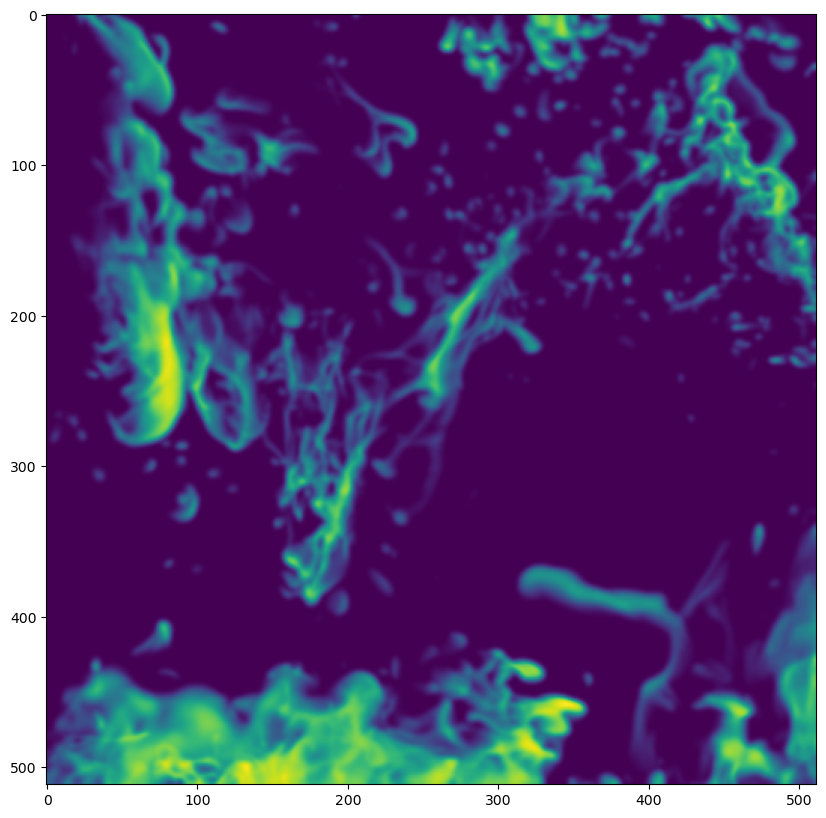

In [20]:
plot_(fcnm_data4)

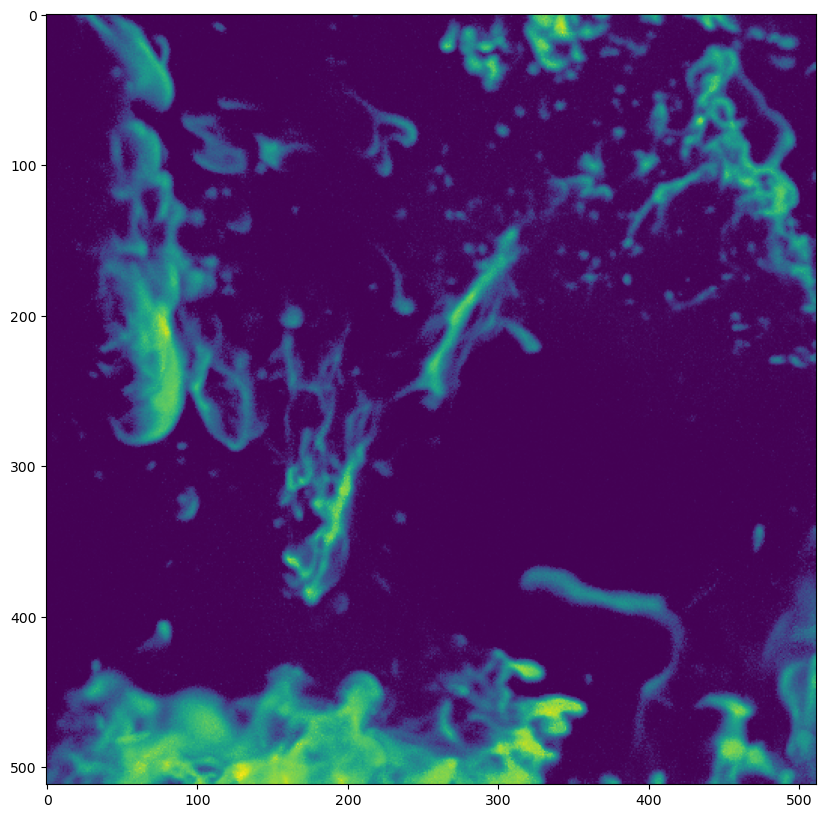

In [17]:
plot_(Fcnm)

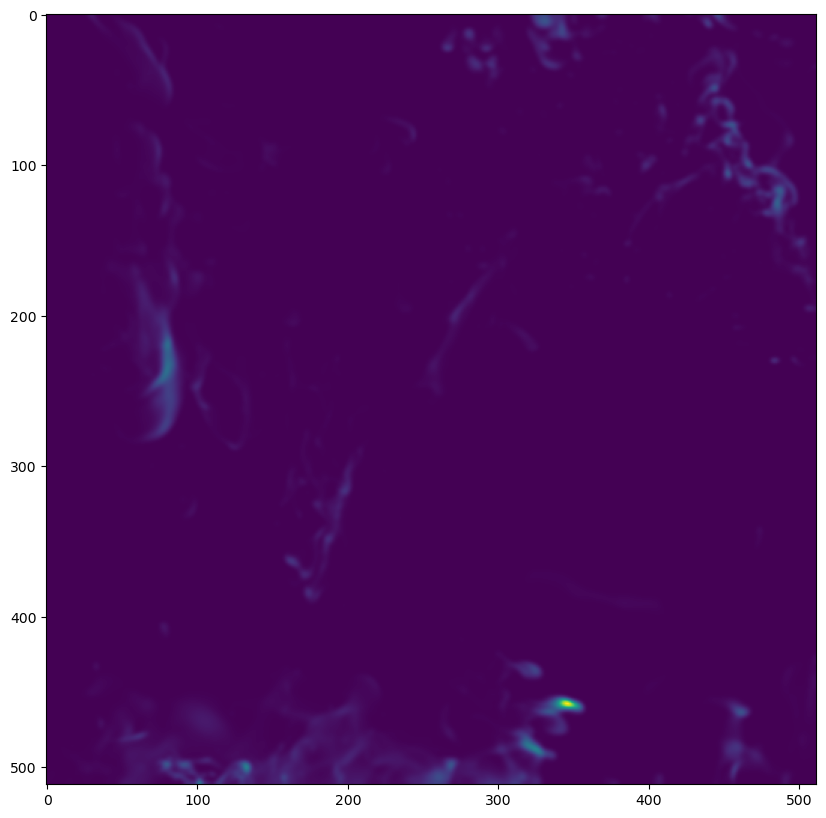

In [21]:
plot_(rhi_data4)

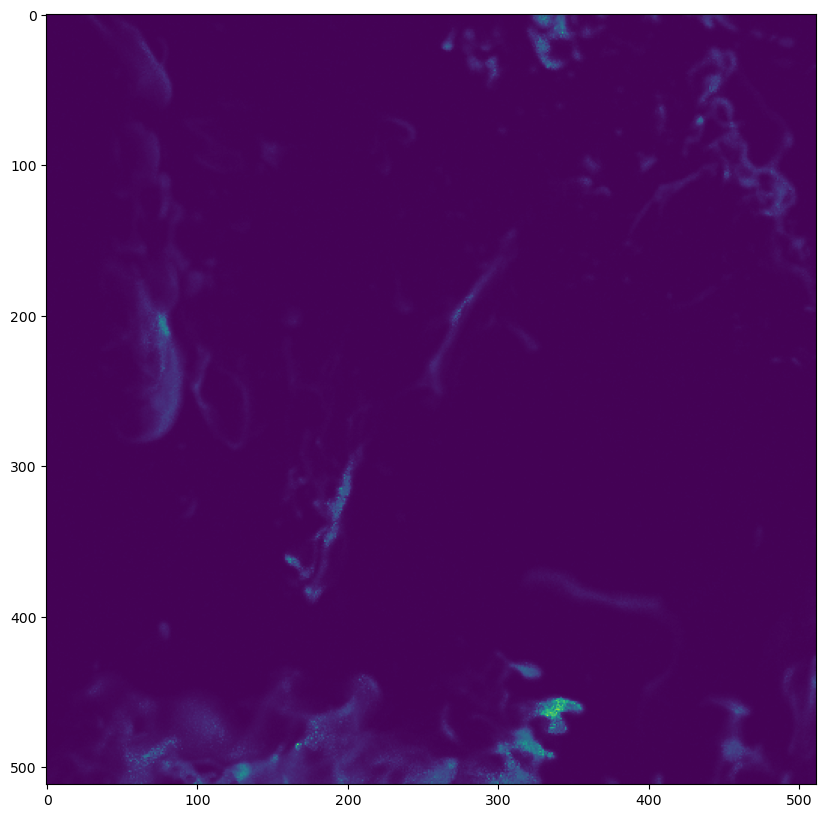

In [22]:
plot_(Rhi)